# AMOC covariance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch
import seaborn as sns

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:36083 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read NEMO mesh

In [6]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

## Read OpenIFS mesh

## Read NEMO stream functions

In [7]:
exp_list = ['FOCI_GJK001','FOCI_GJK001']
label_list = ['Warm phase','Cold phase']
time_list = [slice('2200-01-01','2400-01-01'), slice('2600-01-01','2800-01-01')]

In [8]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_moc_all.append(ds_moc)
    
    psi = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*PSI.nc' % (esmdir,exp,exp)
    print(psi)
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_psi_all.append(ds_psi)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*PSI.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*PSI.nc


In [9]:
# NEMO ice
ds_ice_all = []
for exp,time in zip(exp_list,time_list):
    ice = '/%s/%s/outdata/nemo/%s*1m*icemod.nc' % (esmdir,exp,exp)
    print(ice)
    ds_ice = xr.open_mfdataset(ice,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_ice_all.append(ds_ice)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/FOCI_GJK001*1m*icemod.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/FOCI_GJK001*1m*icemod.nc


## Read OpenIFS data

In [10]:
# OpenIFS surface
ds_sfc_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc


In [ ]:
# OpenIFS surface
ds_sfc_1m_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_1m_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_sfc.nc


## AMOC time series

In [ ]:
amoc_index = []

for i,ds_moc in enumerate(ds_moc_all):
    
    amoc = ds_moc['zomsfatl'].sel(x=0,y=304).max('depthw').groupby('time.year').mean('time').compute()
    amoc_anom = amoc - amoc.mean('year')
    
    amoc_index.append(amoc_anom)

## Correlation with surface variables

In [ ]:
def correlation(x, y, dim='time'):
    cov = ((x - x.mean(dim=dim))* (y - y.mean(dim=dim))).mean(dim=dim)
    corr = cov / x.std(dim=dim) / y.std(dim=dim)
    return corr

def significance(r,n):
    t = r / np.sqrt(1 - r**2) * np.sqrt((n - 2).where(n > 2))
    p_values = t.copy()
    p_values.values = (2 
                       * sns.distributions.stats.t.sf(
                       np.abs(t.where(n>2)),
                       df=n.where(n>2)-2))
    return p_values

In [ ]:
# Plot settings
prj = ccrs.PlateCarree()

cmap = cmocean.cm.balance

i1 = 1
i2 = 0
label = '%s - %s' % (label_list[i1],label_list[i2])

#letters = string.ascii_lowercase

variables = ['sstk','2t','tp','ssf','msl']

# Set up plot
fig1, axs1 = plt.subplots(len(variables),2,figsize=(12,12),subplot_kw={'projection':prj})
ax1 = axs1.flat

for i,v in enumerate(variables): 
    
    scale = 1
    if v == 'sstk':
        vv = 'SST'
        vmax = 2
        
    elif v == '2t':
        vv = 'T2m'
        vmax = 2
    
    elif v == 'ci':
        vv = 'Sea-ice fraction'
        vmax = 0.2
        
    elif v == 'tp':
        scale = 4000 # mm/d
        vv = 'Precip'
        vmax = 1
    
    elif v == 'msl':
        scale = 0.01
        vv = 'MSLP'
        vmax = 1
    
    elif v == 'ssf':
        scale = 1./(6 * 60 * 60)
        vv = 'Turb. heat flux'
        vmax = 20
        
    elif v == 'toa':
        scale = 1./(6 * 60 * 60)
        vv = 'TOA net'
        vmax = 20
    
    for j,(amoc,ds_sfc) in enumerate( zip(amoc_index, ds_sfc_all) ):
        
        if v == 'ssf':
            data1 = ds_sfc['sshf'].groupby('time.year').mean('time').compute() * scale
            data2 = ds_sfc['slhf'].groupby('time.year').mean('time').compute() * scale
            
            data = data1 + data2
            
        elif v == 'toa':
            data1 = ds_sfc['tsr'].groupby('time.year').mean('time').compute() * scale
            data2 = ds_sfc['ttr'].groupby('time.year').mean('time').compute() * scale
            
            data = data1 + data2
        
        else:
            data = ds_sfc[v].groupby('time.year').mean('time').compute() * scale

        # Remove masked data
        nan_mask = ~xr.ufuncs.isnan(data) & ~xr.ufuncs.isnan(amoc)
        data = data.where(nan_mask)
        amoc = amoc.where(nan_mask)
        
        # Compute correlation with AMOC
        r = correlation(amoc, data, dim='year').compute()
        n = nan_mask.sum(dim='year')
        p = significance(r,n).compute()
        
        # Plot
        r.plot(ax=axs1[i,j],vmin=-1,vmax=1,cmap=cmocean.cm.balance,rasterized=True)
        p.plot.contourf(ax=axs1[i,j],levels=(0, 0.05,1.), transform=ccrs.PlateCarree(),
                        colors='none', hatches=(None, '..'),
                        add_colorbar=False,rasterized=True)
        
        axs1[i,j].set_title('r(AMOC,%s) %s' % (vv,label_list[j]))
        
for ax in ax1:
    ax.coastlines()

fig1.savefig('amoc_covariance.pdf',format='pdf')

## Time series of indices

In [ ]:
def ice_area(icefrac):
    icearea = icefrac * da_orca05_area
    ice_sh = icearea[:,0:240,:].sum(('x','y')) * 1e-12 #[million km2]
    ice_nh = icearea[:,240:,:].sum(('x','y'))  * 1e-12 #[million km2]
    return ice_nh, ice_sh 

In [ ]:
def wgtm(data):
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    wgt = data.weighted(weights)
    mean = wgt.mean(('lon','lat'))
    return mean

### Sea-ice area and AMOC

In [ ]:
fig3, ax3 = plt.subplots(2,1,figsize=(6,8))

for j,(amoc,ds_ice) in enumerate( zip(amoc_index, ds_ice_all) ):
    
    # Annual mean
    icefrac_y = ds_ice['ileadfra'].groupby('time.year').mean('time')
    #icefrac_m = ds_ice['ileadfra'].groupby('time.month').mean('time')
    #print(icefrac_m)
    
    # February
    icefrac_2 = ds_ice['ileadfra'].sel(time=ds_ice.time.dt.month == 2)
    # September
    icefrac_9 = ds_ice['ileadfra'].sel(time=ds_ice.time.dt.month == 9)
    
    # Annual anomalies
    icefrac_a = icefrac_y - icefrac_y.mean('year')
    
    # Feb and Sep anomalies
    icefrac_2a = icefrac_2 - icefrac_2.mean('time')
    icefrac_9a = icefrac_9 - icefrac_9.mean('time')
    
    # NH and SH ice areas
    ice_nh, ice_sh = ice_area(icefrac_a)
    ice_nh_2, _tmp = ice_area(icefrac_2a)
    ice_nh_9, _tmp = ice_area(icefrac_9a)
    
    x1 = ice_nh.values
    x2 = ice_sh.values
    y = amoc.values
    t = amoc.year
    
    #fig1, ax1 = plt.subplots(1,3)
    #ax1[0].scatter(ice_nh.values, y)
    #ax1[1].scatter(ice_nh_2.values, y)
    #ax1[2].scatter(ice_nh_9.values, y)
    
    fig2, ax2 = plt.subplots(2,1,figsize=(6,8))
    
    ax2[0].plot(t,ice_nh_2.values,'-b')
    ax2a = ax2[0].twinx()
    ax2a.plot(t,amoc.values,'-r')
    ax2a.set_title('AMOC and NH SIA (Feb), %s' % (label_list[j],))
    
    ax2[1].plot(t,ice_nh_9.values,'-b')
    ax2b = ax2[1].twinx()
    ax2b.plot(t,amoc.values,'-r')
    ax2b.set_title('AMOC and NH SIA (Sep), %s' % (label_list[j],))
    
    ax3[j].plot(t,ice_nh.values,'-b',label='NH SIA')
    ax3a = ax3[j].twinx()
    ax3a.plot(t,amoc.values,'-r',label='AMOC')
    
    for ax in [ax2[0],ax2[1],ax3[j]]:
        ax.set_xlabel('Year')
        ax.set_ylabel('SIA anomaly [million km2]')
        
        ax.spines['left'].set_color('blue')
        
        ax.yaxis.label.set_color('blue')
        
        ax.tick_params(axis='y', colors='blue')
        
    
    for ax in [ax2a, ax2b, ax3a]:
        ax.set_ylabel('AMOC anomaly [Sv]')
        ax.spines['right'].set_color('red')
        ax.yaxis.label.set_color('red')
        ax.tick_params(axis='y', colors='red')
    
    ax3[j].set_title('AMOC and NH SIA, %s' % (label_list[j],))

fig3.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,1)
ds_sfc['sstk'][0,:,:].plot(ax=ax)
ax.plot([290,360,360,290,290],[20,20,70,70,20],'-k')

tmp = ds_sfc['sstk'].sel(lon=slice(290,360),lat=slice(20,70))
na_sst = wgtm(tmp)

## Covariance with surface variables

In [ ]:
def seasonal_means(da):
    # Resample to quarters, starting in Feb
    res = da.resample(time='Q-FEB').mean()
    
    # Compute DJF, MAM, JJA, SON means
    djf = res.sel(time=res['time.month'] == 2).groupby('time.year').mean('time')
    mam = res.sel(time=res['time.month'] == 5).groupby('time.year').mean('time')
    jja = res.sel(time=res['time.month'] == 8).groupby('time.year').mean('time')
    son = res.sel(time=res['time.month'] == 11).groupby('time.year').mean('time')
    
    return djf, mam, jja, son

In [ ]:
fig3, ax3 = plt.subplots(2,1,figsize=(6,8))

lon1 = 290
lon2 = 360
lat1 = 40
lat2 = 70

for j,(amoc,ds_sfc) in enumerate( zip(amoc_index, ds_sfc_1m_all) ):
    
    # Sea surface temp (seen by atm)
    sst = wgtm( ds_sfc['sstk'].sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)) )
    print(sst.values)
    
    # Sensible + latent heat flux [W/m2]
    thf = wgtm( (ds_sfc['sshf'].sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)) + 
                 ds_sfc['slhf'].sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2))) / (6.*60*60) )
    
    # E-P
    emp = wgtm( (ds_sfc['e'].sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)) + 
                 ds_sfc['tp'].sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2))) / (6.*60*60) )
    
    # Annual anomalies
    sst_a = sst.groupby('time.year').mean('time') - sst.groupby('time.year').mean('time').mean('year')
    print(sst_a.values)
    #thf_a = thf.groupby('time.year').mean('time')
    #emp_a = emp.groupby('time.year').mean('time')
    
    # Seasonal 
    sst_djf, _, sst_jja, _ = seasonal_means(sst)
    #sst_djf = sst.where(sst['time.season'] == 'DJF')
    #print(sst_djf)
    #ds_res = ds_res.sel(time=ds_res['time.month'] == 2)
    #ds_res = ds_res.groupby('time.year').mean('time')
    
    # DJF anomalies
    sst_djf_a = sst_djf - sst_djf.mean('year')
    
    # JJA
    sst_djf_a = sst_jja - sst_jja.mean('year')
    
    x1 = ice_nh.values
    x2 = ice_sh.values
    y = amoc.values
    t = amoc.year
    
    #fig1, ax1 = plt.subplots(1,3)
    #ax1[0].scatter(ice_nh.values, y)
    #ax1[1].scatter(ice_nh_2.values, y)
    #ax1[2].scatter(ice_nh_9.values, y)
    
    fig2, ax2 = plt.subplots(2,1,figsize=(6,8))
    
    ax2[0].plot(amoc.year, sst_a.values, '-b')
    ax2a = ax2[0].twinx()
    ax2a.plot(amoc.year, amoc.values, '-r')
    ax2a.set_title('AMOC and N.Atl. SST, %s' % (label_list[j],))
    ax2[0].set_ylabel('SST anomaly [K]')
    
    #ax2[1].plot(t,ice_nh_9.values,'-b')
    #ax2b = ax2[1].twinx()
    #ax2b.plot(t,amoc.values,'-r')
    #ax2a.set_title('AMOC and NH SIA (Sep), %s' % (label_list[j],))
    
    #ax3[j].plot(t,ice_nh.values,'-b',label='NH SIA')
    #ax3a = ax3[j].twinx()
    #ax3a.plot(t,amoc.values,'-r',label='AMOC')
    
    for ax in [ax2[0],ax2[1],ax3[j]]:
        ax.set_xlabel('Year')
        ax.spines['left'].set_color('blue')
        ax.yaxis.label.set_color('blue')
        ax.tick_params(axis='y', colors='blue')
    
    for ax in [ax2a, ax2b, ax3a]:
        ax.set_ylabel('AMOC anomaly [Sv]')
        ax.spines['right'].set_color('red')
        ax.yaxis.label.set_color('red')
        ax.tick_params(axis='y', colors='red')
    
    ax3[j].set_title('AMOC and NH SIA, %s' % (label_list[j],))

fig3.tight_layout()

<xarray.DataArray 'zomsfatl' (year: 200)>
array([ 1.7864113 ,  0.50205517,  0.29708385, -1.3160896 ,  0.99588394,
        0.25728893, -1.22153   , -0.37003613, -0.99000263, -1.0606852 ,
       -1.3219757 ,  0.2443285 , -0.5900583 , -1.090785  , -0.59352493,
       -1.784955  , -2.5488577 , -1.9647217 , -1.347642  , -1.2389803 ,
        0.08708286, -0.09961605, -0.7848139 , -1.5918531 , -1.772788  ,
       -1.1697187 ,  0.3893118 ,  1.947546  ,  2.7105408 ,  3.3881474 ,
        2.4886303 ,  2.4370441 ,  1.6148014 , -0.1046896 ,  1.4692154 ,
        0.11363888,  0.53360367,  0.6106653 , -0.3815298 , -0.03739548,
        0.7051277 ,  0.53388596,  1.0461597 ,  1.1229877 , -0.2665472 ,
        0.67427444, -0.5677872 , -0.56448746,  0.5107908 ,  1.3197918 ,
        0.7087145 ,  1.1695156 , -0.6787844 ,  1.1066303 ,  1.9998817 ,
        1.3887119 , -0.23902225, -0.403718  ,  1.3455029 ,  1.5416965 ,
        1.8706284 ,  2.6515942 ,  0.76753616,  1.2589417 ,  0.45067883,
        0.39781094,  0

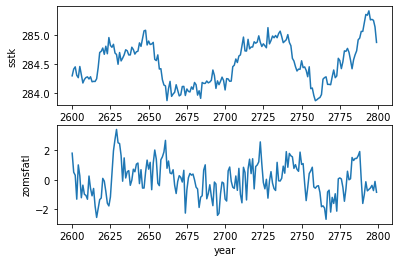

In [19]:
fig, ax = plt.subplots(2,1)
na_sst.groupby('time.year').mean('time').plot(ax=ax[0])
print(amoc)
amoc.plot(ax=ax[1])